# Team Topic Thunder
### CS 410, Fall 2021

# Topic Model Evaluation

Mine topics of CS 410 course projects for a range of k = number of topics.

Next, generate a model with optimal k, and use the pyLDAvis library to visualize topic coverage and overlap.

Then, output results:
* The dominant topic for each CS 410 project
* The most representative project documentation for each topic
* The optimal model
* The dictionary and corpus

Finally, edit `LDA.py` to produce the final output for the [Topic Thunder web app](https://topic-thunder-a7103.web.app/) to consume

## Step 1: Import Packages and Cleaned Text

Note that this doesn't include code for text preprocessing. That's done as a separate step in `text_cleaning.py`.

### Ignore deprecation warnings and import required packages

In [1]:
import pandas as pd
from ast import literal_eval #to convert file from a string as we are reading from .tsv

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import cleaned project text, and build a dictionary and document-term matrix

In [31]:
# Import cleaned text
df=pd.read_csv('../project_clean_text.tsv',sep='\t',converters={'clean_text': literal_eval})
df.head()

,project_url,file_text,clean_text
0,https://github.com/17JamesH/CourseProject,project progress report team member task progr...,"[remaining, risk, james, crawling, redfin, wor..."
1,https://github.com/97agupta/CourseProject,team 'buddie' project proposal 1. what are the...,"[buddie, proposal, netids, administrative, dut..."
2,https://github.com/AShipway/CourseProject,aaron shipway cs 410 fall '21 project progress...,"[aaron, shipway, fall, completed, established,..."
3,https://github.com/AlexZurski/CourseProject,alexander zurawski azuraws2 cs 410 11/15/2021 ...,"[alexander, zurawski, azuraws, final, complete..."
4,https://github.com/AnantSharma18/CourseProject,page 1 of 2 project progress report anant ashu...,"[anant, ashutosh, sharma, anantas, edu, indivi..."


## Step 2: Form Bigrams

Identify frequent pairs of words. Bigrams should easier for human readers to interpret than unigrams are.

Code copied and adapted from [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [32]:
# Get cleaned text as list for further processing.

clean_text = df['clean_text'].to_list()

In [65]:
# Build bigram model. Set min_count and threshold arguments arbitrarily.
# These are hyperparameters, so would have to be learned to achieve more targeted values.

bigram = Phrases(clean_text, min_count=5, threshold=15)
bigram_phraser = Phraser(bigram)

In [66]:
# Finally, create bigrammed/trigrammed version of clean_text for further processing.

megalist = [bigram_phraser[doc] for doc in clean_text]

## Step 3: Generate Dictionary and Corpus

In [68]:
# creating a dictionary from the list of lists
dictionary=corpora.Dictionary(megalist)

In [69]:
# Term Document Frequency
doc_term_matrix = [dictionary.doc2bow(doc, allow_update=True) for doc in megalist]

## Step 4: Generate Models

Generate models for a range of k = number of topics.

Also compute perplexity and coherence scores for each model.

Again, code borrowed from [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [23]:
# Routine to generate and score models for a range of k.

def generate_and_score_models(dictionary, corpus, texts, limit, start=2, step=2, random_state=100, alpha="auto"):
    """
   Generate topic models for a range of topic counts.
   Evaluate coherence for each topic count, and return lists.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_values: The log of the perplexity of the corresponding LDA model.
    """
    model_list = []
    coherence_values = []
    log_perplexity_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics, 
                         random_state=random_state,  # For repeatability
                         passes=10,
                         iterations=50,
                         alpha=alpha)  # Use "auto" to learn the document-topic distribution
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        log_perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, log_perplexity_values

In [70]:
# Generate models for the given range of k

start = 2
step = 2
limit = 40

model_list, coherence_values, log_perplexity_values = generate_and_score_models(dictionary=dictionary,
                                                                                corpus=doc_term_matrix,
                                                                                texts=megalist,
                                                                                limit=limit,
                                                                                start=start,
                                                                                step=step,
                                                                                random_state=100,
                                                                                alpha="auto")

## Step 3: Review Results

### Review coherence scores

Topic coherence is partly based on the conditional likelihood of co-occurrence of words in a topic. Coherence helps to measure how well-related a topic's words are to each other. For more, see the article [Topic Model Evaluation](https://highdemandskills.com/topic-model-evaluation).

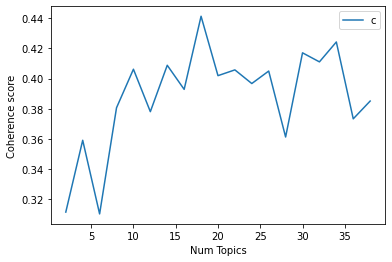

In [71]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [72]:
for k, cv in zip(x, coherence_values):
    print("Num Topics =", k, "has Coherence Value of", round(cv, 4))

Num Topics = 2 has Coherence Value of 0.3114
Num Topics = 4 has Coherence Value of 0.3591
Num Topics = 6 has Coherence Value of 0.3102
Num Topics = 8 has Coherence Value of 0.3806
Num Topics = 10 has Coherence Value of 0.4062
Num Topics = 12 has Coherence Value of 0.378
Num Topics = 14 has Coherence Value of 0.4088
Num Topics = 16 has Coherence Value of 0.3928
Num Topics = 18 has Coherence Value of 0.4413
Num Topics = 20 has Coherence Value of 0.4019
Num Topics = 22 has Coherence Value of 0.4057
Num Topics = 24 has Coherence Value of 0.3967
Num Topics = 26 has Coherence Value of 0.405
Num Topics = 28 has Coherence Value of 0.3612
Num Topics = 30 has Coherence Value of 0.417
Num Topics = 32 has Coherence Value of 0.4111
Num Topics = 34 has Coherence Value of 0.4242
Num Topics = 36 has Coherence Value of 0.3733
Num Topics = 38 has Coherence Value of 0.3851


Coherence rises to a local peak at 10 topics, then hits a higher peak at 18 topics.

It's common practice to pick the first model that hits peak coherence before plateauing. These coherence scores don't form a plateau, however, which may reflect topic instability.

### Review log-perplexity scores

Topic perplexity is proportional to the inverse probability of a test set against the topics mined from a training set. Perplexity is computed from held-out data. A lower perplexity reflects a better topic model. For more, see the article [Perplexity in Language Models](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94).

However, the article [Topic Model Evaluation](https://highdemandskills.com/topic-model-evaluation) suggests that models with better perplexity scores are harder for humans to interpret.

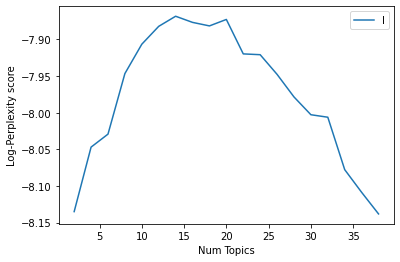

In [73]:
x = range(start, limit, step)
plt.plot(x, log_perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Log-Perplexity score")
plt.legend(("log_perplexity_values"), loc='best')
plt.show()

In [74]:
for k, lpv in zip(x, log_perplexity_values):
    print("Num Topics =", k, "has Log-Perplexity Value of", round(lpv, 4))

Num Topics = 2 has Log-Perplexity Value of -8.135
Num Topics = 4 has Log-Perplexity Value of -8.047
Num Topics = 6 has Log-Perplexity Value of -8.0293
Num Topics = 8 has Log-Perplexity Value of -7.9466
Num Topics = 10 has Log-Perplexity Value of -7.9066
Num Topics = 12 has Log-Perplexity Value of -7.8822
Num Topics = 14 has Log-Perplexity Value of -7.8685
Num Topics = 16 has Log-Perplexity Value of -7.8768
Num Topics = 18 has Log-Perplexity Value of -7.8816
Num Topics = 20 has Log-Perplexity Value of -7.8728
Num Topics = 22 has Log-Perplexity Value of -7.9198
Num Topics = 24 has Log-Perplexity Value of -7.9209
Num Topics = 26 has Log-Perplexity Value of -7.9477
Num Topics = 28 has Log-Perplexity Value of -7.9785
Num Topics = 30 has Log-Perplexity Value of -8.0028
Num Topics = 32 has Log-Perplexity Value of -8.0062
Num Topics = 34 has Log-Perplexity Value of -8.0777
Num Topics = 36 has Log-Perplexity Value of -8.1086
Num Topics = 38 has Log-Perplexity Value of -8.1381


As we're aiming for low log-perplexity, the only options seem to be models with 6 or fewer topics, or 34 or more. Since low-perplexity topic models can be harder for humans to interpret, and CS 410 projects cover more than 6 topics, we'll focus more on coherence.

### Examine highlighted topic models

Review the models with 8, 10 and 18 topics.

View the topics themselves, and generate pyLDAvis breakdowns to help gauge topic sizes and degrees of overlap.

In pyLDAvis, overlap or close proximity of topics indicates high similarity. Generally, we should look for models with well-separated topics. For more information, see [pyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know).

#### 8-topic model

In [75]:
# Show topics for the 8-topic model
pprint(model_list[3].print_topics(num_words=10))

[(0,
  '0.008*"stock" + 0.008*"rating" + 0.007*"search" + 0.007*"sentiment" + '
  '0.007*"model" + 0.006*"text" + 0.005*"twitter" + 0.005*"system" + '
  '0.004*"recipe" + 0.004*"sentiment_analysis"'),
 (1,
  '0.031*"pattern" + 0.017*"context" + 0.011*"frequent_pattern" + '
  '0.010*"model" + 0.008*"mining" + 0.007*"context_unit" + 0.006*"transaction" '
  '+ 0.005*"algorithm" + 0.005*"term" + 0.005*"two"'),
 (2,
  '0.008*"model" + 0.008*"text" + 0.008*"topic" + 0.006*"document" + '
  '0.006*"search" + 0.006*"sentiment" + 0.005*"algorithm" + '
  '0.005*"information" + 0.005*"api" + 0.005*"sentiment_analysis"'),
 (3,
  '0.008*"system" + 0.006*"search" + 0.006*"window" + 0.006*"container" + '
  '0.005*"docker" + 0.004*"area" + 0.004*"time" + 0.004*"card" + '
  '0.004*"function" + 0.004*"app"'),
 (4,
  '0.029*"topic" + 0.010*"url" + 0.010*"model" + 0.007*"faculty" + '
  '0.007*"text" + 0.006*"document" + 0.006*"system" + 0.005*"time_series" + '
  '0.004*"algorithm" + 0.004*"time"'),
 (5,
  

pyLDAvis output for the 8-topic model

In [76]:
vis_8_topics = pyLDAvis.gensim_models.prepare(model_list[3], doc_term_matrix, dictionary=model_list[3].id2word)
vis_8_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.052175  0.023963       1        1  27.412934
2      0.050471 -0.028513       2        1  25.633699
4      0.039874  0.005351       3        1  16.670628
0      0.056048 -0.046124       4        1   7.509945
6      0.061128 -0.006032       5        1   6.812259
5     -0.167917 -0.122167       6        1   6.550241
1     -0.076954  0.183919       7        1   6.297785
3      0.089525 -0.010397       8        1   3.112510, topic_info=                     Term         Freq        Total Category  logprob  loglift
1926      twitter_sarcasm  1975.000000  1975.000000  Default  30.0000  30.0000
9036  twitter_not_sarcasm  1140.000000  1140.000000  Default  29.0000  29.0000
2546              pattern   531.000000   531.000000  Default  28.0000  28.0000
132                 topic  2154.000000  2154.000000  Default  27.0000  27.0000
821               context   688.000000   688.000000  Default  26.0000  26.0000
...                   ...          ...          ...      ...      ...      ...
128                  text    24.808329  1640.087219   Topic8  -5.7616  -0.7216
72            information    21.276598   748.278180   Topic8  -5.9152  -0.0904
133                  type    18.611070   222.944386   Topic8  -6.0491   0.9866
471                  show    18.162642   267.945865   Topic8  -6.0735   0.7783
4                     api    18.082312   459.853115   Topic8  -6.0779   0.2338

[617 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14798      3  0.985864  _________
9876       4  0.946692    _player
5443       1  0.967298  able_beat
12559      5  0.910811        acc
0          1  0.074793   activity
...      ...       ...        ...
4670       2  0.926157       yarn
532        1  0.019162  york_time
532        2  0.038323  york_time
532        3  0.919762  york_time
17067      8  0.906259    zhengyu

[1709 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 5, 1, 7, 6, 2, 4])

_Screenshot of pyLDAvis output for 8-topic model_
![Screenshot of pyLDAvis output for 8-topic model](8_topic_model_pyLDAvis_overall.png)

#### 10-topic model

In [77]:
# Model with 10 topics
pprint(model_list[4].print_topics(num_words=10))

[(0,
  '0.010*"stock" + 0.009*"rating" + 0.008*"model" + 0.006*"text" + '
  '0.006*"sentiment" + 0.005*"recipe" + 0.005*"system" + 0.005*"search" + '
  '0.005*"library" + 0.004*"twitter"'),
 (1,
  '0.035*"pattern" + 0.019*"context" + 0.013*"frequent_pattern" + '
  '0.008*"context_unit" + 0.008*"mining" + 0.007*"transaction" + 0.006*"term" '
  '+ 0.006*"algorithm" + 0.006*"given" + 0.006*"model"'),
 (2,
  '0.009*"topic" + 0.009*"text" + 0.007*"sentiment" + 0.007*"model" + '
  '0.005*"search" + 0.005*"sentiment_analysis" + 0.005*"algorithm" + '
  '0.005*"api" + 0.005*"twitter" + 0.005*"plan"'),
 (3,
  '0.008*"container" + 0.006*"system" + 0.005*"search_engine" + 0.005*"app" + '
  '0.004*"docker" + 0.004*"time" + 0.004*"search" + 0.003*"however" + '
  '0.003*"aspect" + 0.003*"original"'),
 (4,
  '0.028*"topic" + 0.011*"model" + 0.010*"url" + 0.007*"faculty" + '
  '0.007*"text" + 0.006*"system" + 0.006*"algorithm" + 0.006*"document" + '
  '0.005*"time_series" + 0.004*"time"'),
 (5,
  '0.17

pyLDAvis output for 10 topics

In [78]:
vis_10_topics = pyLDAvis.gensim_models.prepare(model_list[4], doc_term_matrix, dictionary=model_list[4].id2word)
vis_10_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.053738 -0.057830       1        1  23.237570
7     -0.047449 -0.016634       2        1  20.277189
4      0.034754 -0.014071       3        1  15.963164
6      0.026544 -0.030024       4        1   8.271796
8      0.055286  0.097113       5        1   8.055066
9      0.054671 -0.084796       6        1   7.792631
1      0.033025  0.204362       7        1   5.587154
0      0.030613 -0.068860       8        1   5.338416
5     -0.260691  0.004279       9        1   4.172767
3      0.019507 -0.033538      10        1   1.304248, topic_info=                     Term         Freq        Total Category  logprob  loglift
1926      twitter_sarcasm  1909.000000  1909.000000  Default  30.0000  30.0000
9036  twitter_not_sarcasm  1101.000000  1101.000000  Default  29.0000  29.0000
357                 model  4660.000000  4660.000000  Default  28.0000  28.0000
2546              pattern   542.000000   542.000000  Default  27.0000  27.0000
1761                 bert   819.000000   819.000000  Default  26.0000  26.0000
...                   ...          ...          ...      ...      ...      ...
30                 create     9.764107   688.598729  Topic10  -5.8243   0.0836
87                    may     9.013300   443.905979  Topic10  -5.9043   0.4426
144                  able     8.322369   403.666248  Topic10  -5.9841   0.4579
481                source     8.162264   386.865564  Topic10  -6.0035   0.4810
136               website     7.948303   374.680219  Topic10  -6.0301   0.4864

[748 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14798      3  0.975001  _________
6068      10  0.868723        _cs
9876       1  0.948702    _player
6272      10  0.867221      aarch
144        1  0.324526       able
...      ...       ...        ...
532        7  0.019002  york_time
17065     10  0.710331      yuran
17066     10  0.710835     yuranw
4020      10  0.461254      yuxin
17067     10  0.843947    zhengyu

[2230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 5, 7, 9, 10, 2, 1, 6, 4])

_Screenshot of pyLDAvis output for 10-topic model_
![Screenshot of pyLDAvis output for 10-topic model](10_topic_model_pyLDAvis_overall.png)

#### 18-topic model

In [79]:
# Model with 18 topics
pprint(model_list[8].print_topics(num_words=10))

[(0,
  '0.012*"stock" + 0.010*"rating" + 0.009*"model" + 0.007*"sentiment" + '
  '0.007*"text" + 0.006*"system" + 0.006*"search" + 0.005*"market" + '
  '0.005*"twitter" + 0.005*"library"'),
 (1,
  '0.040*"pattern" + 0.021*"context" + 0.015*"frequent_pattern" + '
  '0.010*"context_unit" + 0.009*"mining" + 0.008*"transaction" + 0.007*"term" '
  '+ 0.007*"algorithm" + 0.006*"given" + 0.006*"dblp"'),
 (2,
  '0.011*"model" + 0.010*"topic" + 0.010*"text" + 0.006*"document" + '
  '0.006*"algorithm" + 0.005*"system" + 0.005*"plan" + 0.005*"sentiment" + '
  '0.004*"different" + 0.004*"time"'),
 (3,
  '0.015*"card" + 0.009*"search_engine" + 0.008*"deck" + 0.008*"website" + '
  '0.007*"system" + 0.007*"email" + 0.005*"educationalweb" + 0.005*"api" + '
  '0.005*"bulk" + 0.005*"pdf"'),
 (4,
  '0.028*"topic" + 0.013*"url" + 0.012*"model" + 0.010*"faculty" + '
  '0.007*"document" + 0.006*"text" + 0.006*"system" + 0.005*"corpus" + '
  '0.005*"algorithm" + 0.005*"directory"'),
 (5,
  '0.017*"topic" + 0

pyLDAvis output for 18 topics

In [80]:
vis_18_topics = pyLDAvis.gensim_models.prepare(model_list[8], doc_term_matrix, dictionary=model_list[8].id2word)
vis_18_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.068841 -0.052401       1        1  17.854065
2      0.072314 -0.015901       2        1  15.622555
4      0.055821 -0.051851       3        1  11.044074
9      0.082074  0.040215       4        1   5.697996
8     -0.040253 -0.184123       5        1   5.686964
6      0.043268 -0.003919       6        1   5.643868
12    -0.019139 -0.056825       7        1   5.185110
1     -0.018390 -0.139495       8        1   5.152612
11     0.070814  0.020441       9        1   5.072454
5      0.035921 -0.035166      10        1   5.040300
0      0.045559  0.006229      11        1   4.632449
13    -0.007355 -0.105992      12        1   3.202158
10    -0.329982  0.066463      13        1   2.667202
15     0.055230  0.124289      14        1   2.630102
17     0.067080  0.097882      15        1   2.401692
14     0.056513  0.074468      16        1   1.785900
3     -0.013030  0.109711      17        1   0.636830
16    -0.087604  0.105974      18        1   0.043669, topic_info=                     Term         Freq        Total Category  logprob  loglift
1926      twitter_sarcasm  1954.000000  1954.000000  Default  30.0000  30.0000
9036  twitter_not_sarcasm  1129.000000  1129.000000  Default  29.0000  29.0000
132                 topic  2162.000000  2162.000000  Default  28.0000  28.0000
357                 model  4737.000000  4737.000000  Default  27.0000  27.0000
2546              pattern   568.000000   568.000000  Default  26.0000  26.0000
...                   ...          ...          ...      ...      ...      ...
1970               amazon     0.129873    68.054043  Topic18  -6.7475   1.4748
729                system     0.143764   773.656385  Topic18  -6.6459  -0.8544
1185             building     0.129657   189.948507  Topic18  -6.7491   0.4467
617           text_mining     0.127205   156.012393  Topic18  -6.7682   0.6244
132                 topic     0.128430  2162.746558  Topic18  -6.7586  -1.9952

[1299 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
14798      3  0.972856     _________
9874       9  0.953162           _bm
6068      13  0.717782           _cs
9876       9  0.973201       _player
3825      12  0.942997         aamrq
...      ...       ...           ...
17143     13  0.855345  zainal_hakim
17144     13  0.855346       zainalh
6750       2  0.888772          zhan
10504     12  0.846933     zhangzhou
17067     17  0.844472       zhengyu

[4589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 5, 10, 9, 7, 13, 2, 12, 6, 1, 14, 11, 16, 18, 15, 4, 17])

_Screenshot of pyLDAvis output for 18-topic model_
![Screenshot of pyLDAvis output for 18-topic model](18_topic_model_pyLDAvis_overall.png)

## Step 4: Choose Optimal Model and Output Its Document/Topic Relationships

The Twitter sarcasm-detection theme has appeared for all examined models.

Other topics have separated as k increased.

All other things being equal, the 12-topic model has the highest coherence score. Most of the topics overlap, but it's reasonable for CS 410 projects to share common concepts, approaches and tools, even when their aims differ.

We'll consider the 12-topic model to be optimal.

In [20]:
optimal_model = model_list[5]

### Identify the dominant topic in each CS 410 project

Once again, code borrowed from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [21]:
def format_topics_docs(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_docs_keywords = format_topics_docs(ldamodel=optimal_model, corpus=doc_term_matrix, texts=megalist)

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

# Show
df_dominant_topic.head(10)

,document_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,8.0,0.9354,"tweet, sentiment, model, text, topic, analysis...","[remaining, risk, james, crawling, redfin, wor..."
1,1,9.0,0.8913,"topic, time, series, text, modeling, causal, a...","[buddie, proposal, netids, administrative, dut..."
2,2,10.0,0.5532,"analysis, sentiment, topic, text, tweet, time,...","[aaron, shipway, fall, completed, established,..."
3,3,2.0,0.8989,"slide, document, system, lecture, topic, model...","[alexander, zurawski, azuraws, final, complete..."
4,4,8.0,0.8482,"tweet, sentiment, model, text, topic, analysis...","[anant, ashutosh, sharma, anantas, edu, indivi..."
5,5,10.0,0.9004,"analysis, sentiment, topic, text, tweet, time,...","[paste, cmt, detailed, instruction, activity]"
6,6,0.0,0.6764,"topic, search, faculty, url, system, model, te...","[reddit, recommenders, completed, divided, amo..."
7,7,8.0,0.9913,"tweet, sentiment, model, text, topic, analysis...","[proposal, song, retrieval, sentiment, analysi..."
8,8,2.0,0.9995,"slide, document, system, lecture, topic, model...","[andrew, sciotti, sciotti, completed, complete..."
9,9,8.0,0.6761,"tweet, sentiment, model, text, topic, analysis...","[completed, frontend, completed, created, chro..."


Output dominant topic for each document, both as standalone table and combined with original document dataframe.

In [22]:
# Output dominant topics
df_dominant_topic.to_csv("./Optimal_Model_Dom_Topic_Per_Doc.tsv", sep="\t", index=False)

In [23]:
# Merge list of dominant topics with original list of CS 410 project URLs and text.
df_project_dominant_topic = df.join(df_dominant_topic, how="inner")

In [24]:
# Output combined dataframe.
df_project_dominant_topic[["document_no", "project_url", "dominant_topic", "topic_perc_contrib", "keywords", "text"]].to_csv("./Optimal_Model_Dom_Topic_Doc_Output.tsv", sep="\t", index=False)

### Identify the most representative document for each topic

In [25]:
doc_topics_sorted_df = pd.DataFrame()

doc_topics_grouped = df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in doc_topics_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['topic_num', "topic_perc_contrib", "keywords", "text"]

# Show
doc_topics_sorted_df.head(len(doc_topics_sorted_df))

,topic_num,topic_perc_contrib,keywords,text
0,0.0,0.9999,"topic, search, faculty, url, system, model, te...","[improving, expertsearch, plan, automate, scra..."
1,1.0,0.9998,"topic, aspect, analysis, rating, recipe, model...","[final, topic, mining, healthcare, completed, ..."
2,2.0,0.9998,"slide, document, system, lecture, topic, model...","[final, improving, system, philip, cori, pcori..."
3,3.0,0.9999,"model, pattern, collection, context, text, min...","[generating, semantic, annotation, frequent, p..."
4,4.0,0.9999,"twitter, sarcasm, not_sarcasm, model, bert, re...","[topic, bert, sentiment, analysis, detect, twi..."
5,5.0,0.9999,"model, lstm, layer, text, bert, embedding, con...","[fall, text, classification, sandeep, nanjegow..."
6,6.0,0.9999,"stock, sentiment, rating, market, system, comp...","[topic, stock, recommender, system, background..."
7,7.0,0.9999,"model, bert, text, classification, competition...","[cody, webster, made, thus, far, generic, wrot..."
8,8.0,0.9998,"tweet, sentiment, model, text, topic, analysis...","[sentiment, analysis, soccer, game, natural, l..."
9,9.0,0.9999,"topic, time, series, text, modeling, causal, a...","[mining, causal, topic, text, iterative, topic..."


In [26]:
# Output the most representative doc for each topic.
doc_topics_sorted_df.to_csv("./Optimal_Model_Rep_Doc_Per_Topic.tsv", sep="\t", index=False)

### Save model

Save the optimal model, dictionary and corpus to disk.

In [27]:
# Save the model
optimal_model.save("./saved_model/Optimal_LDA_Model.model")

# Save dictionary
dictionary.save("./saved_model/Dictionary.dict")

# Save corpus / doc-term matrix
corpora.MmCorpus.serialize("./saved_model/Doc_Term_Matrix.corpus", doc_term_matrix)

## Where to Go From Here

Edit `LDA.py` to produce final output files `AlgOutput.tsv`and `firebase-output.json`. The JSON file is for the [Topic Thunder web app](https://topic-thunder-a7103.web.app/) to consume. 

To edit `LDA.py`, either load the saved optimal model from disk, or rerun GenSim LdaModel with the same settings that produced the optimal model.